In [1]:
# テスト windowで抽出
import boto3
import rasterio as rio
from rasterio.windows import Window
import matplotlib.pyplot as plt
import numpy as np
from pyproj import Transformer
import datetime
import re
import os

s3_bucket = "helios-rs-datalake"  # 自分のS3バケット名


b4file = 'Project/arkedge-sbir/Sentinel2/Paraguay-Desmochados/T21JUL_20220401T140051_B04_10m.tif'
b8file = 'Project/arkedge-sbir/Sentinel2/Paraguay-Desmochados/T21JUL_20220401T140051_B08_10m.tif'
B4 = rio.open('s3://' + s3_bucket + '/' + b4file)

width, height = B4.width // 2, B4.height // 2
window = Window(width, 0, width, height) #i, j, tile_width, tile_height 右上
transform = B4.window_transform(window)

meta = B4.meta.copy()
meta.update({
    'driver': 'GTiff',
    "count": 1,  # 出力バンド数
    'width': window.width,
    'height': window.height,
    "dtype": "float32",
    'transform': transform
})

B4 = B4.read(1, window=window).astype('float')
B8 = rio.open('s3://' + s3_bucket + '/' + b8file).read(1, window=window).astype('float')
NDVI = (B8 - B4) / (B8 + B4)

# 一旦ローカル保存後、アップロードして、ローカル削除
s3 = boto3.client("s3")
s3_bucket = "helios-rs-datalake"  # 自分のS3バケット名
outputname = 'T21JUL_20220401T140051_NDVI.tif'
s3_key = 'Project/arkedge-sbir/Sentinel2/Paraguay-Desmochados/saiga_tmp/' + outputname

local_file_path = "../../tmp/" + outputname
with rio.open(local_file_path, "w", **meta) as dst:
    dst.write(NDVI.astype(rio.float32), 1)

s3.upload_file(local_file_path, s3_bucket, s3_key)

os.remove(local_file_path)

# outputname = 'T21JUL_20220401T140051_NDVI.tif'
# OUTPUT_IMAGE_PATH =s3_key + outputname
# with rio.open('s3://' + s3_bucket + '/' + s3_key, "w", **meta) as dst:
#     dst.write(NDVI.astype(rio.float32), 1)


7/112error
80/112error
112/112        dates      ndvi  year month_day month_day_dt
0  2022-04-01  0.225325  2022     04-01   1900-04-01
1  2022-04-13  0.218549  2022     04-13   1900-04-13
2  2022-04-18  0.259796  2022     04-18   1900-04-18
3  2022-04-23  0.277424  2022     04-23   1900-04-23
4  2022-05-06  0.305062  2022     05-06   1900-05-06
5  2022-05-08  0.324206  2022     05-08   1900-05-08
6  2022-05-13  0.327364  2022     05-13   1900-05-13
7  2022-05-16  0.323613  2022     05-16   1900-05-16
8  2022-05-18  0.312133  2022     05-18   1900-05-18
9  2022-05-23  0.327390  2022     05-23   1900-05-23
10 2022-06-02  0.323145  2022     06-02   1900-06-02
11 2022-06-12  0.317914  2022     06-12   1900-06-12
12 2022-06-15  0.302072  2022     06-15   1900-06-15
13 2022-06-30  0.280382  2022     06-30   1900-06-30
14 2022-07-25  0.227585  2022     07-25   1900-07-25
15 2022-08-14  0.217511  2022     08-14   1900-08-14
16 2022-08-19  0.235225  2022     08-19   1900-08-19
17 2022-08-21  0

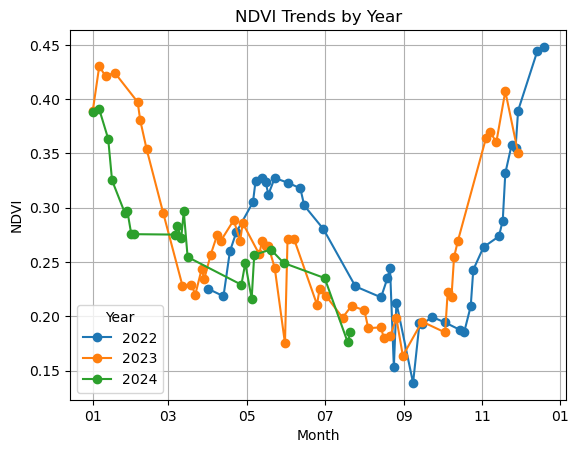

In [6]:
import boto3
import rasterio as rio
from rasterio.windows import Window
import matplotlib.pyplot as plt
import numpy as np
from pyproj import Transformer
import datetime
import re
import os
import pandas as pd
import matplotlib.dates as mdates

sys.path.append('../util')
import common

# S3バケット名を指定
s3 = boto3.client("s3")
s3_bucket = "helios-rs-datalake"  # 自分のS3バケット名
prefix = "Project/arkedge-sbir/Sentinel2/Paraguay-Desmochados/NDVI/"  # バケット内のフォルダパス

# ファイル一覧を入手
file_list = common.get_filelist(s3, s3_bucket, prefix)

# 条件に一致するファイルを抽出
NDVI_files = [path for path in file_list if "_NDVI" in path]

NDVI_means = []
dates = []
# for i in range(15): #test
for i in range(len(NDVI_files)):
    print("\r"+str(i+1) + '/' + str(len(NDVI_files)),end="")
    try:
        ndvi = rio.open('s3://' + s3_bucket + '/' + NDVI_files[i])

        width, height = 500, 500 # ndvi.width // 2, ndvi.height // 2
        window = Window(9100, 1300, width, height) # i, j, tile_width, tile_height 右上
        # window = Window(9300, 1000, width, height) # i, j, tile_width, tile_height 右上
        transform = ndvi.window_transform(window)
        
        meta = ndvi.meta.copy()
        meta.update({
            'driver': 'GTiff',
            "count": 1,  # 出力バンド数
            'width': window.width,
            'height': window.height,
            "dtype": "float32",
            'transform': transform
        })

        ndvi = ndvi.read(1, window=window).astype('float')
        if (np.mean(ndvi) != 0):
            dates.append(common.extract_date(NDVI_files[i]))
            NDVI_means.append(np.mean(ndvi))
        else:
            print("error ", NDVI_files[i])
    except Exception as e:
        print(f"Error reading files: {e}")
dates = [datetime.datetime.strptime(str(date), "%Y%m%d") for date in dates]

# plt.figure()
# plt.plot(dates, NDVI_means, marker='o')
# plt.gcf().autofmt_xdate()
# plt.xlabel('Date')
# plt.show()

df = pd.DataFrame({'dates':dates, 'ndvi':NDVI_means})
# df.to_csv('ndvi_means.csv')

df["dates"] = pd.to_datetime(df["dates"])
df["year"] = df["dates"].dt.year
df["month_day"] = df["dates"].dt.strftime("%m-%d")
df["month_day_dt"] = pd.to_datetime(df["month_day"], format="%m-%d")
# データを年ごとにグループ化
unique_years = df["year"].unique()

plt.figure()
for year in unique_years:
    yearly_data = df[df["year"] == year]
    plt.plot(yearly_data["month_day_dt"], yearly_data["ndvi"], marker="o", label=str(year))
    print(yearly_data)

# 軸ラベルとタイトル
plt.xlabel("Month")
plt.ylabel("NDVI")
plt.title("NDVI Trends by Year")
plt.legend(title="Year")
plt.grid()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%m"))


file:  Project/arkedge-sbir/Sentinel2/Paraguay-Desmochados/NDVI/T21JUL_20220401T140051_NDVI_10m.tif
0.22532524106230586
file:  Project/arkedge-sbir/Sentinel2/Paraguay-Desmochados/NDVI/T21JUL_20220423T135109_NDVI_10m.tif
0.2774236312050228
file:  Project/arkedge-sbir/Sentinel2/Paraguay-Desmochados/NDVI/T21JUL_20220511T140101_NDVI_10m.tif
error
file:  Project/arkedge-sbir/Sentinel2/Paraguay-Desmochados/NDVI/T21JUL_20220518T135121_NDVI_10m.tif
0.31213286342738755
file:  Project/arkedge-sbir/Sentinel2/Paraguay-Desmochados/NDVI/T21JUL_20220612T134709_NDVI_10m.tif
0.3179143799452819
file:  Project/arkedge-sbir/Sentinel2/Paraguay-Desmochados/NDVI/T21JUL_20220725T135709_NDVI_10m.tif
0.22758462896394638
file:  Project/arkedge-sbir/Sentinel2/Paraguay-Desmochados/NDVI/T21JUL_20220821T134709_NDVI_10m.tif
0.2447744021743685


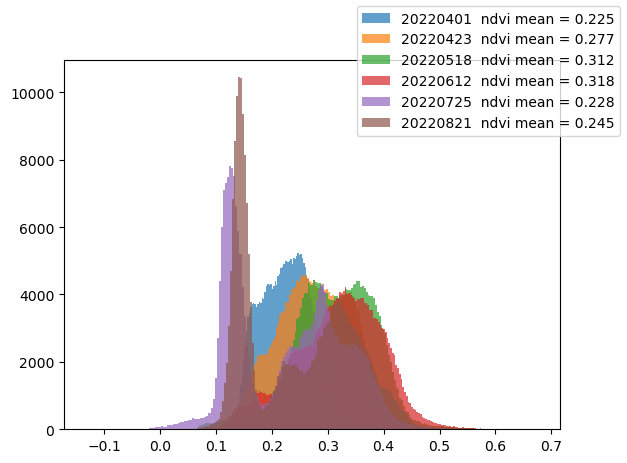

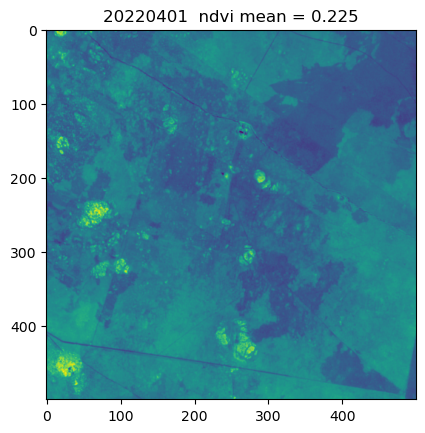

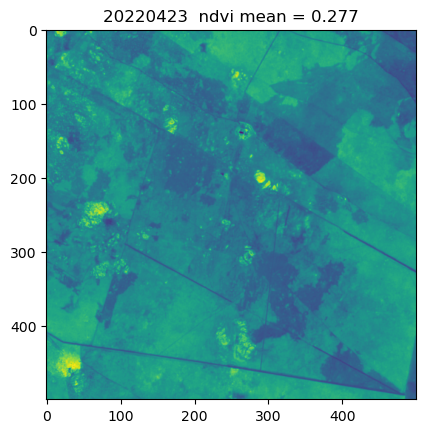

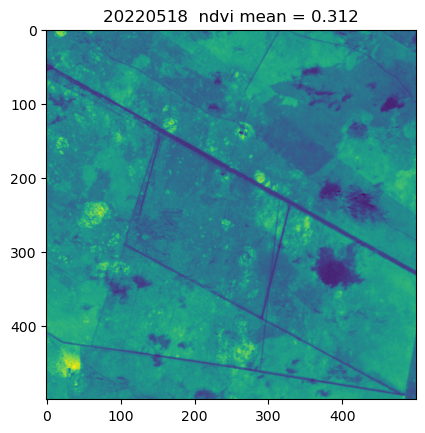

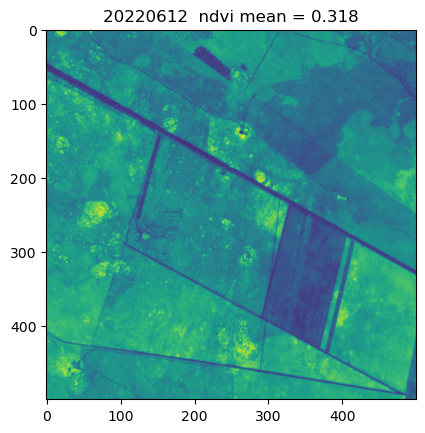

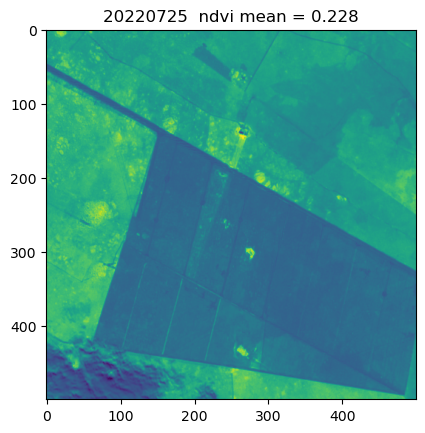

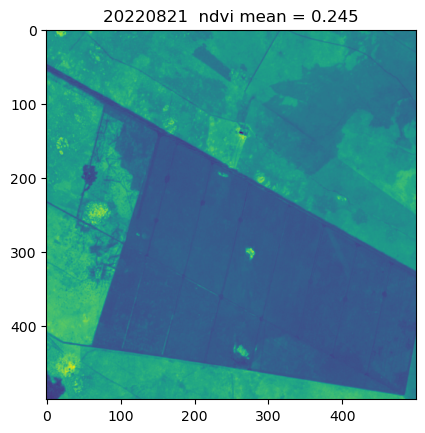

In [5]:
import boto3
import rasterio as rio
from rasterio.windows import Window
import matplotlib.pyplot as plt
import numpy as np
from pyproj import Transformer
import datetime
import re
import os
import sys

sys.path.append('../util')
import common

# S3バケット名を指定
s3 = boto3.client("s3")
s3_bucket = "helios-rs-datalake"  # 自分のS3バケット名
prefix = "Project/arkedge-sbir/Sentinel2/Paraguay-Desmochados/NDVI/"  # バケット内のフォルダパス

# ファイル一覧を入手
file_list = common.get_filelist(s3, s3_bucket, prefix)

# 条件に一致するファイルを抽出
NDVI_files = [path for path in file_list if "_NDVI" in path]

plot_index = range(0, 20, 3) # 2022 夏
# plot_index = range(25, 49,2) #2022 成長時期
# plot_index = range(43, 50, 1) #2023 収穫時期
# plot_index = range(90, 95,1) #2024 収穫時期
# plot_index = range(38, 55, 4) # 2023 初頭の変化抜粋
# for i in range(15): #test
fig, ax = plt.subplots()
for i in plot_index:
    print('file: ', NDVI_files[i])
    try:
        ndvi = rio.open('s3://' + s3_bucket + '/' + NDVI_files[i])

        width, height = 500, 500 # ndvi.width // 2, ndvi.height // 2
        window = Window(9100, 1300, width, height) # i, j, tile_width, tile_height 右上
        transform = ndvi.window_transform(window)
        
        meta = ndvi.meta.copy()
        meta.update({
            'driver': 'GTiff',
            "count": 1,  # 出力バンド数
            'width': window.width,
            'height': window.height,
            "dtype": "float32",
            'transform': transform
        })

        ndvi = ndvi.read(1, window=window).astype('float')
        ndvi_mean = np.mean(ndvi)
        date_str = str(common.extract_date(NDVI_files[i])) + '  ndvi mean = ' + str(round(ndvi_mean, 3))
        if (ndvi_mean != 0):
            print(ndvi_mean)
            fig2, ax2 = plt.subplots()
            ax2.imshow(ndvi)
            ax2.set_title(date_str)
            fig2.show()
            ax.hist(ndvi.ravel(), bins=200,alpha=0.7,label=date_str)
        else:
            print("error")
    except Exception as e:
        print(f"Error reading files: {e}")

fig.legend()
fig.show()

In [7]:
df.to_csv('../../data/ndvi_means.csv')

[[ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 ...
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]]


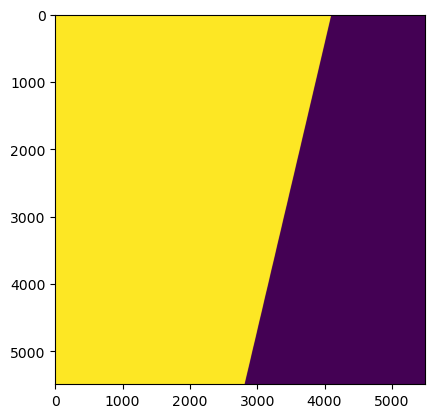

In [2]:


import boto3
import rasterio as rio
from rasterio.windows import Window
import matplotlib.pyplot as plt
import numpy as np
from pyproj import Transformer
import datetime
import re
import os
import sys

sys.path.append('../util')
import common
import online_variance

# S3バケット名を指定
s3 = boto3.client("s3")
s3_bucket = "helios-rs-datalake"  # 自分のS3バケット名
prefix = "Project/arkedge-sbir/Sentinel2/Paraguay-Desmochados/NDVI/"  # バケット内のフォルダパス

mask = common.get_mask(s3, s3_bucket, "Project/arkedge-sbir/Sentinel2/Paraguay-Desmochados")
plt.imshow(mask)
print(mask)

In [ ]:
import boto3
import rasterio as rio
from rasterio.windows import Window
import matplotlib.pyplot as plt
import numpy as np
from pyproj import Transformer
import datetime
import re
import os
import sys

sys.path.append('../util')
import common
import online_variance

# S3バケット名を指定
s3 = boto3.client("s3")
s3_bucket = "helios-rs-datalake"  # 自分のS3バケット名
prefix = "Project/arkedge-sbir/Sentinel2/Paraguay-Desmochados/NDVI/"  # バケット内のフォルダパス

# ファイル一覧を入手
file_list = common.get_filelist(s3, s3_bucket, prefix)

# 条件に一致するファイルを抽出
NDVI_files = [path for path in file_list if "_NDVI" in path]

mask_process = False
msk_str = ''
if mask_process:
    # マスク処理
    mask = common.get_mask(s3, s3_bucket, "Project/arkedge-sbir/Sentinel2/Paraguay-Desmochados/")
    msk_str = '_masked'

online_var = online_variance.OnlineVariance()
for i in range(len(NDVI_files)):
    print("\r"+str(i+1) + '/' + str(len(NDVI_files)),end="")
    try:
        ndvi = rio.open('s3://' + s3_bucket + '/' + NDVI_files[i])

        meta = ndvi.meta.copy()
        meta.update({
            "count": 1,  # 出力バンド数
            "dtype": "float32",
        })

        ndvi = ndvi.read(1).astype(np.float16)
        if mask_process:
            ndvi[mask] = 0
        online_var.update(ndvi)

    except Exception as e:
        print(f"Error reading files: {e}")
  
var = online_var.get_variance()
output = 'Project/arkedge-sbir/Sentinel2/Paraguay-Desmochados/Saiga/ndvi_variance' + msk_str + '.tif'
common.s3_upload(s3, s3_bucket, output, var, meta)

# plt.figure()
# plt.imshow(var)
print(var)

print('\n done')


96/112